This notebook goes through how to draw a single **chip** by **bending** a **cylinder**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape, hard_binarization
from spomso.cores.geom_3d import Cylinder
from spomso.cores.geom import GenericGeometry

# PARAMETERS

In [2]:
# size of the volume
co_size = 3, 3, 2
# resolution of the volume
co_resolution = 150, 150, 100

show = "FIELD" # BINARY, FIELD
show_midplane = True
show_3d = False

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Define the **displacement** function which represents the ribs on the chips:

In [4]:
def displace(co_, A_, P_):
    return A_*np.sin(co_[1]*P_*np.pi*2)

Create a **cylinder** with a **radius** of **1** and **thickness** of **0.1**:

In [5]:
cy = Cylinder(1, 0.05)

Rotate the **cylinder** so it is aligned with the **y-axis**:

In [6]:
cy.rotate(np.pi/2, (1, 0, 0))

Extract the SDF of the **cylinder**, and create new geometry:

In [7]:
modified_cylinder_sdf = cy.propagate
chip_s1 = GenericGeometry(modified_cylinder_sdf, ())

## First Bend

**Bend** the new geometry with the **bending radius** of **1.75** and **bending angle** of **π**:

In [8]:
chip_s1.bend(1.75, np.pi)

<function spomso.cores.modifications.ModifyObject.bend.<locals>.new_geo_object(co, *params)>

Reorient the new geometry for the second bend:

In [9]:
chip_s1.rotate(np.pi/2, (0, 1, 0))

## Second Bend

Extract the SDF from the previous stage, and create new geometry from the extracted SDF:

In [10]:
chip_s1_sdf = chip_s1.propagate
chip_s2 = GenericGeometry(chip_s1_sdf, ())

**Bend** the new geometry with the **bending radius** of **1.75** and **bending angle** of **π**:

In [11]:
chip_s2.bend(1.75, np.pi)

<function spomso.cores.modifications.ModifyObject.bend.<locals>.new_geo_object(co, *params)>

Reorient the new geometry:

In [12]:
chip_s2.rotate(np.pi/2, (1, 0, 0))

## Displacement

Extract the SDF from the previous stage, and create new geometry from the extracted SDF:

In [13]:
chip_s2_sdf = chip_s2.propagate
chip = GenericGeometry(chip_s2_sdf, ())

Add **displacement** to the surface:

In [14]:
chip.displacement(displace, (0.02, 10))

<function spomso.cores.modifications.ModifyObject.displacement.<locals>.new_geo_object(co, *params)>

The parameters of the **displace** function are **0.02** and **10**.

## EVALUATE

Evaluate the SDF of the **chip** to create a signed distance field 3D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [15]:
chip_pattern = chip.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [16]:
if show_midplane:
    field = smarter_reshape(chip_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(chip_pattern, 0)

# PLOT

Drawing results...
(151, 151, 101)


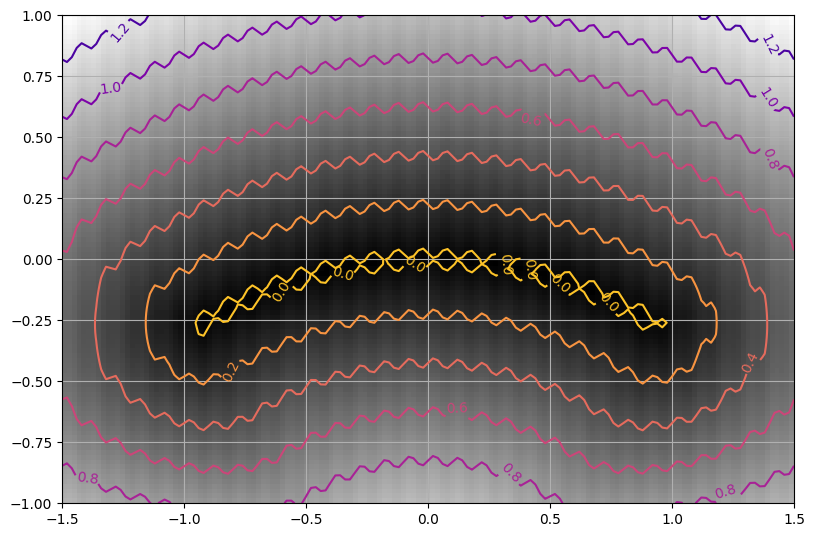

In [17]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[co_resolution[0]//2, :, :].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[2]/2, co_size[2]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    print(field.shape)
    ax.imshow(field[co_resolution[0]//2, :, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[2] / 2, co_size[2] / 2),
              origin="lower"
              )
    x_mask = coor[1] == 0
    cs = ax.contour(coor[0, x_mask].reshape(co_res_new[0], co_res_new[2]),
                    coor[2, x_mask].reshape(co_res_new[0], co_res_new[2]),
                    field[co_resolution[0]//2, :, :],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [18]:
# Isosurfaces plot
if show_3d and show=="BINARY":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=pattern,
        isomin=0.1,
        isomax=1,
        opacity=0.1,
        surface_count=2,
    ))
    fig.show()

if show_3d and show=="FIELD":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=chip_pattern,
        isomin=-0,
        isomax=0.5,
        opacity=0.1,
        surface_count=5,
    ))
    fig.show()
